# **_Texture Segmentations_**

<br>

### __*Import Libraries*__

In [1]:
import cv2
import numpy as np
from scipy import fft
from skimage import io
import matplotlib.pyplot as plt

<br>

### __*Visualization Function*__

In [2]:
def show_fft_segs(img, img_seg):
    plt.figure(figsize=(20, 15))

    plt.subplot(121)
    plt.title('Original Image')
    plt.imshow(img, cmap='gray')

    plt.subplot(122)
    plt.title('Segmented Image')
    plt.imshow(np.log(1 + np.abs(img_seg)))

def compare_img(img1, img2, txt1='Original Image', txt2='Segmented Image'):
    plt.figure(figsize=(20, 15))

    plt.subplot(121)
    plt.title(txt1)
    plt.imshow(img1, cmap='gray')

    plt.subplot(122)
    plt.title(txt2)
    plt.imshow(img2, cmap='gray')

<br>

### __*Fourier Transformation*__

In [3]:
PIC_N = 10

TM_PATH = ''.join(['textury_train/tm', str(PIC_N), '_1_1.png'])
GT_PATH = ''.join(['textury_train/gt', str(PIC_N), '_1.png'])
MK_PATH = ''.join(['textury_train/mask', str(PIC_N), '_1.png'])

image = io.imread(TM_PATH).astype(np.uint8)
image_ground = io.imread(GT_PATH).astype(np.uint8)
image_mask = io.imread(MK_PATH).astype(np.uint8)

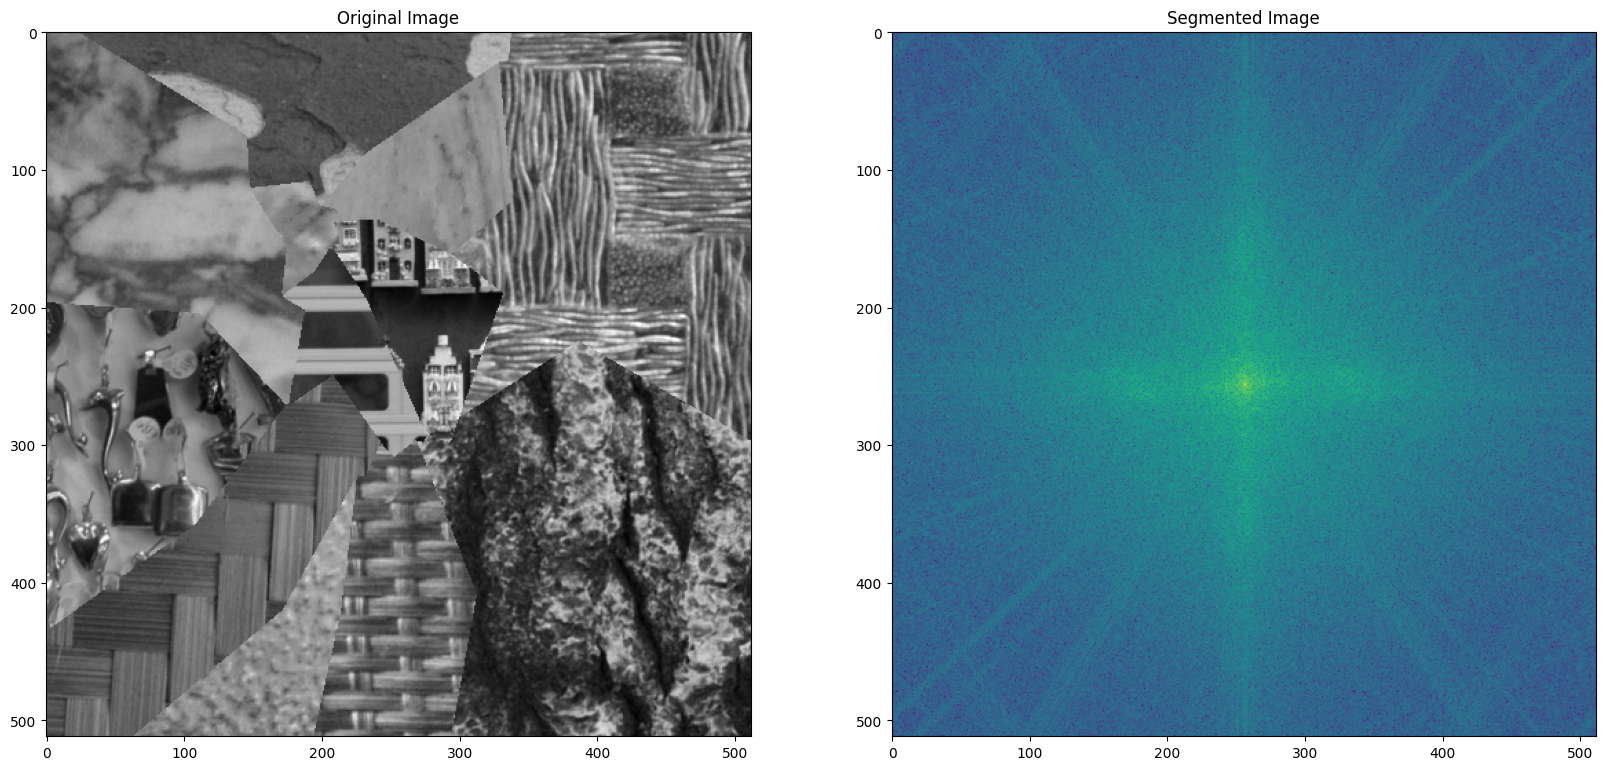

In [4]:
def furrier(img):
    return fft.fftshift(fft.fft2(img))

furry = furrier(image)
show_fft_segs(image, furry)

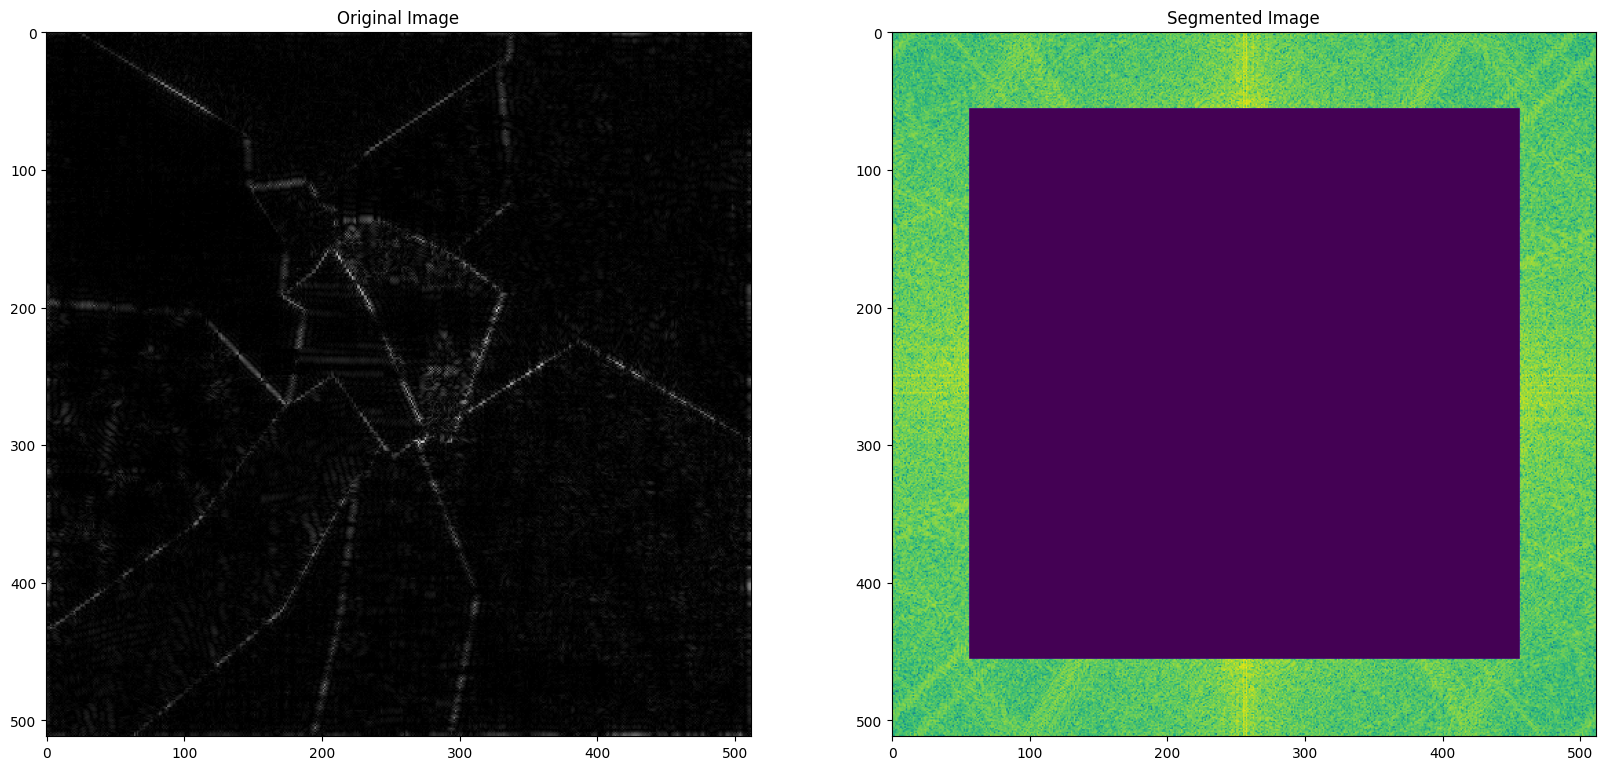

In [5]:
def edge_finder(img):
    pixels = 200
    img_size = img.shape
    filt_spect = img

    # Set a rectangular region in the frequency domain to zero (high-pass filter)
    filt_spect[img_size[0] // 2 - pixels:img_size[0] // 2 + pixels, img_size[1] // 2 - pixels:img_size[1] // 2 + pixels] = 0 + 0j

    # inverse 2D Fourier Transform
    inverse_img = fft.ifft2(filt_spect)

    return np.abs(inverse_img).astype(np.uint8), filt_spect

edge = edge_finder(furry)
show_fft_segs(edge[0], edge[1])

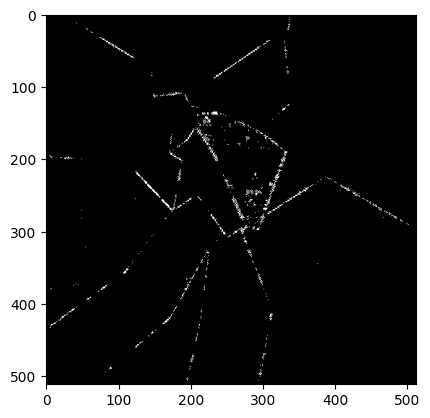

In [6]:
def masker(img):
    edge_img = np.abs(img) / np.max(np.abs(img))
    threshold = 0.2

    edges = edge_img > threshold

    # Delete edge noice
    edges[:5] = False
    edges[:, :5] = False
    edges[-5:] = False
    edges[:, -5:] = False

    return edges.astype(np.uint8)

mask = masker(edge[0])
plt.imshow(mask, cmap='gray')
plt.show()

<br>

### __*Create lines*__

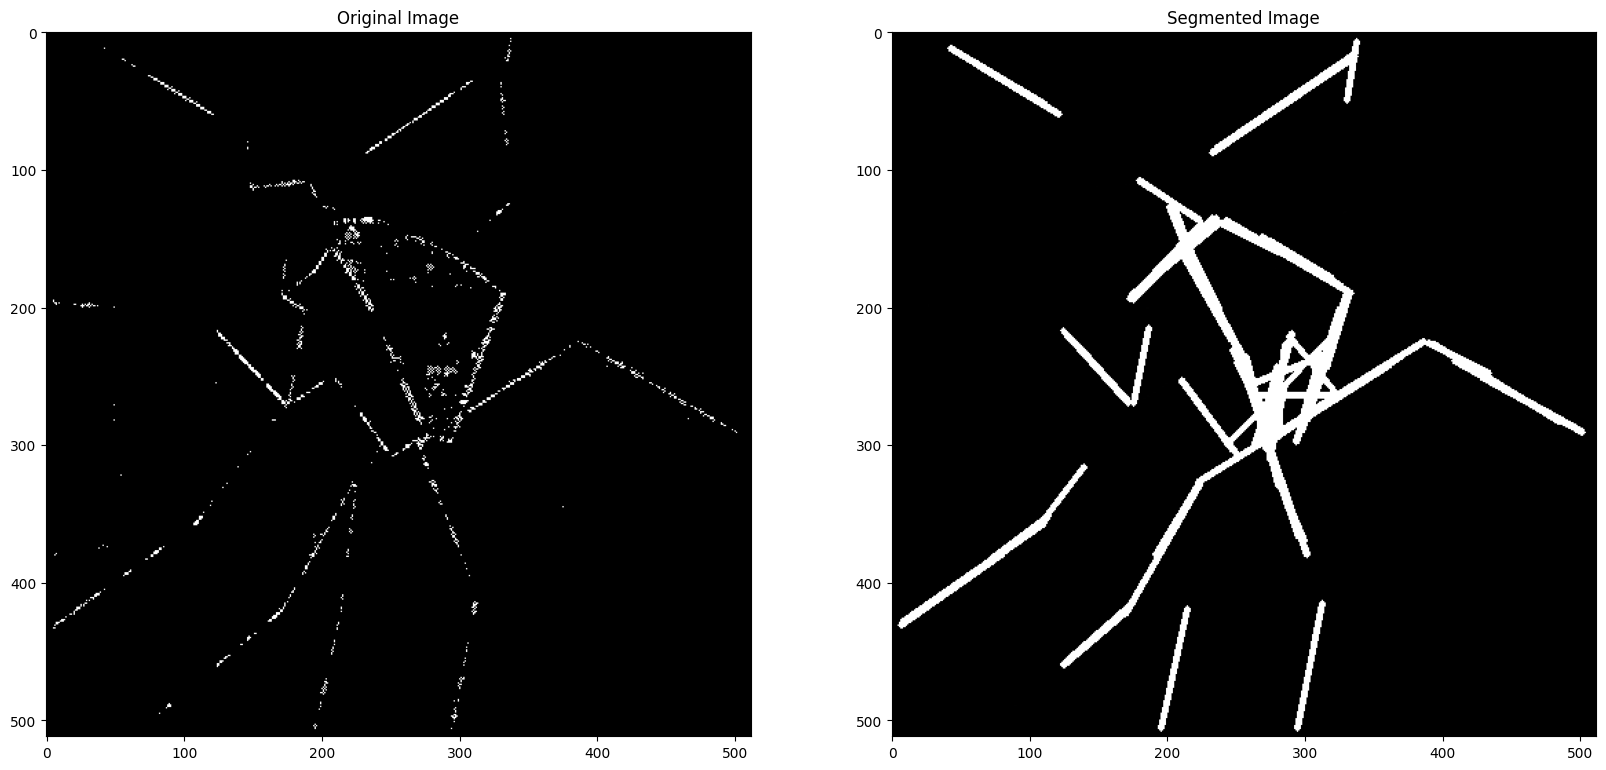

In [7]:
def maskerer(img):
    lines = cv2.HoughLinesP(img, 1, np.pi / 200, threshold=10, minLineLength=40, maxLineGap=30)

    # Draw lines on a copy of the original image
    outp = img.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(outp, (x1, y1), (x2, y2), (255, 255, 255), 3)

    return outp.astype(np.uint8)

pro_mask = maskerer(mask)
compare_img(mask, pro_mask)

<br>

### __*Segmentation*__

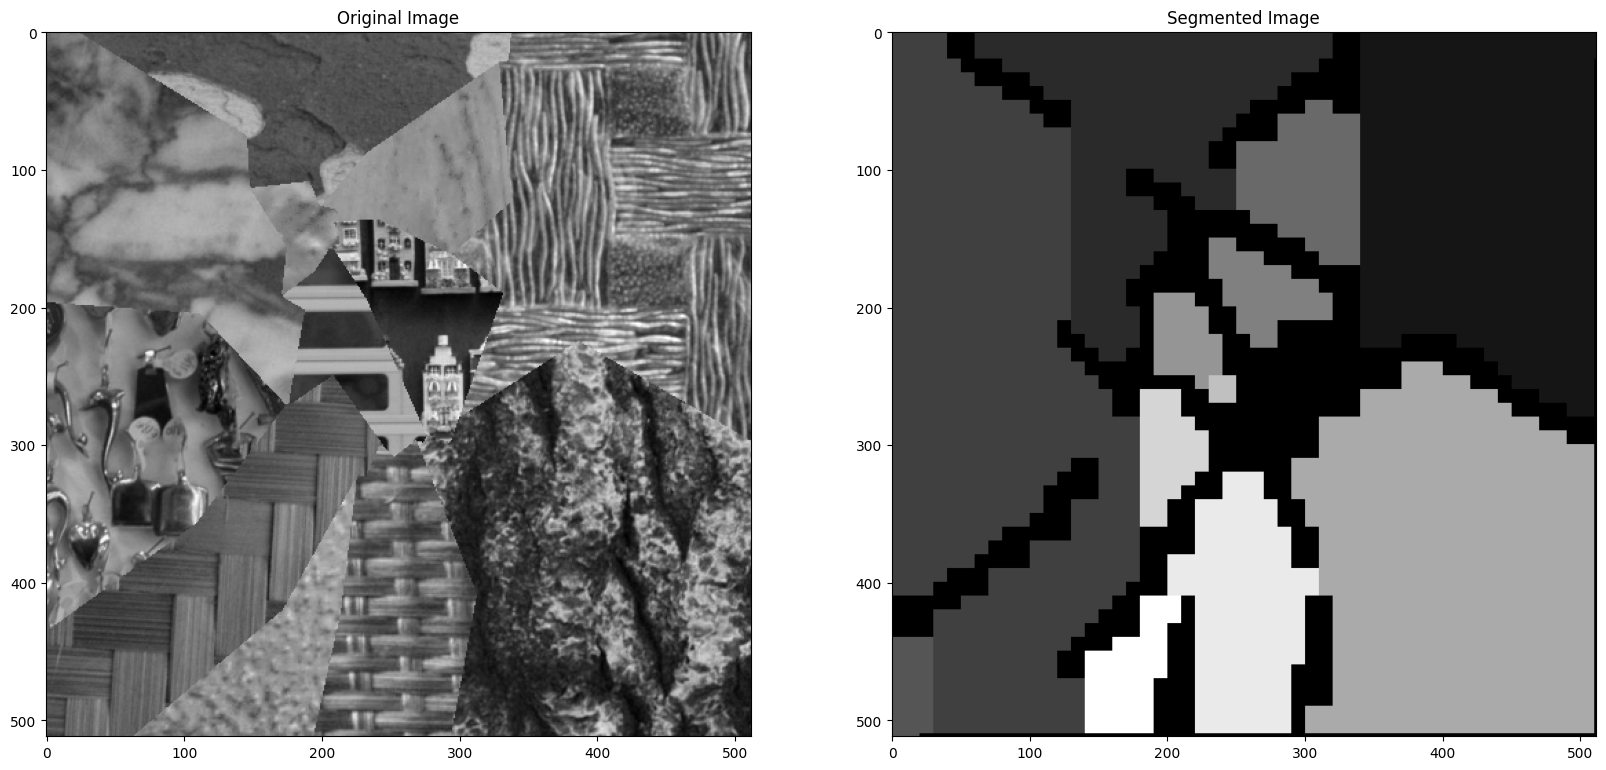

In [8]:
def blocky(img_mask, square=20, threshold=255):
    area = 1
    sqr_size = square
    pixel_threshold = threshold
    ground_truth_outp = np.full((image.shape[0],image.shape[1]), 0)

    # 1st Row
    for x in range(int(image.shape[0]/sqr_size)*2, -1, -1):
        square = img_mask[:sqr_size, int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))]
        if np.sum(square) < pixel_threshold:
            ground_truth_outp[:sqr_size, int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))] = area
        elif np.any(ground_truth_outp == area):
            area += 1

    # 1st Column
    for y in range(2, int(image.shape[1]/sqr_size)*2+1):
        square = img_mask[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), :sqr_size]
        if np.sum(square) < pixel_threshold:
            ground_truth_outp[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), :sqr_size] = area
        elif np.any(ground_truth_outp == area):
            area += 1

    # rest of the rows, row by row
    for y in range(1, int(image.shape[1]/sqr_size)*2):
        for x in range(1, int(image.shape[1]/sqr_size)*2):
            square = img_mask[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), \
                     int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))]
            if np.sum(square) < pixel_threshold:
                # corner values
                upF = ground_truth_outp[int(sqr_size*(y/2))+int(sqr_size/2)-1][int(sqr_size*(x/2))]
                upL = ground_truth_outp[int(sqr_size*(y/2))+int(sqr_size/2)-1][int(sqr_size*(x/2))+sqr_size-1]
                leftF = ground_truth_outp[int(sqr_size*(y/2))][int(sqr_size*(x/2))+int(sqr_size/2)-1]
                leftL = ground_truth_outp[int(sqr_size*(y/2))+sqr_size-1][int(sqr_size*(x/2))+int(sqr_size/2)-1]

                # copy up if [0] == [-1] of the square above & if not 0 & if left = 0
                if upF == upL and (upF != 0 or upL != 0) and (upL == leftL or leftL == 0):
                    ground_truth_outp[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), \
                    int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))] = upF

                # copy left if [0] == [-1] of the square of the left & if not 0 & if up = 0
                elif leftF == leftL and (leftF != 0 or leftL != 0) and (upL == leftL or upL == 0):
                    ground_truth_outp[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), \
                    int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))] = leftF

                elif upL == 0 and leftL == 0:
                    new_x = x
                    try:
                        while ground_truth_outp[int(sqr_size*(y/2))+int(sqr_size/2)-1][int(sqr_size*(new_x/2))+sqr_size-1] == 0 \
                                and (np.sum(img_mask[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)),
                                            int(sqr_size*(new_x/2)):int(((sqr_size*(new_x+2))/2))]) < pixel_threshold):
                            new_x += 1

                        if ground_truth_outp[int(sqr_size*(y/2))+int(sqr_size/2)-1][int(sqr_size*(new_x/2))+sqr_size-1] == 0:
                            ground_truth_outp[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), \
                            int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))] = area
                        else:
                            ground_truth_outp[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), \
                            int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))] = ground_truth_outp[int(sqr_size*(y/2))+int(sqr_size/2)-1] \
                                [int(sqr_size*(new_x/2))+sqr_size-1]
                    except IndexError:
                        pass

            elif np.any(ground_truth_outp == area):
                area += 1

    return ground_truth_outp

almost_segs = blocky(pro_mask)
compare_img(image, almost_segs)

<br>

### __*Interpolation*__

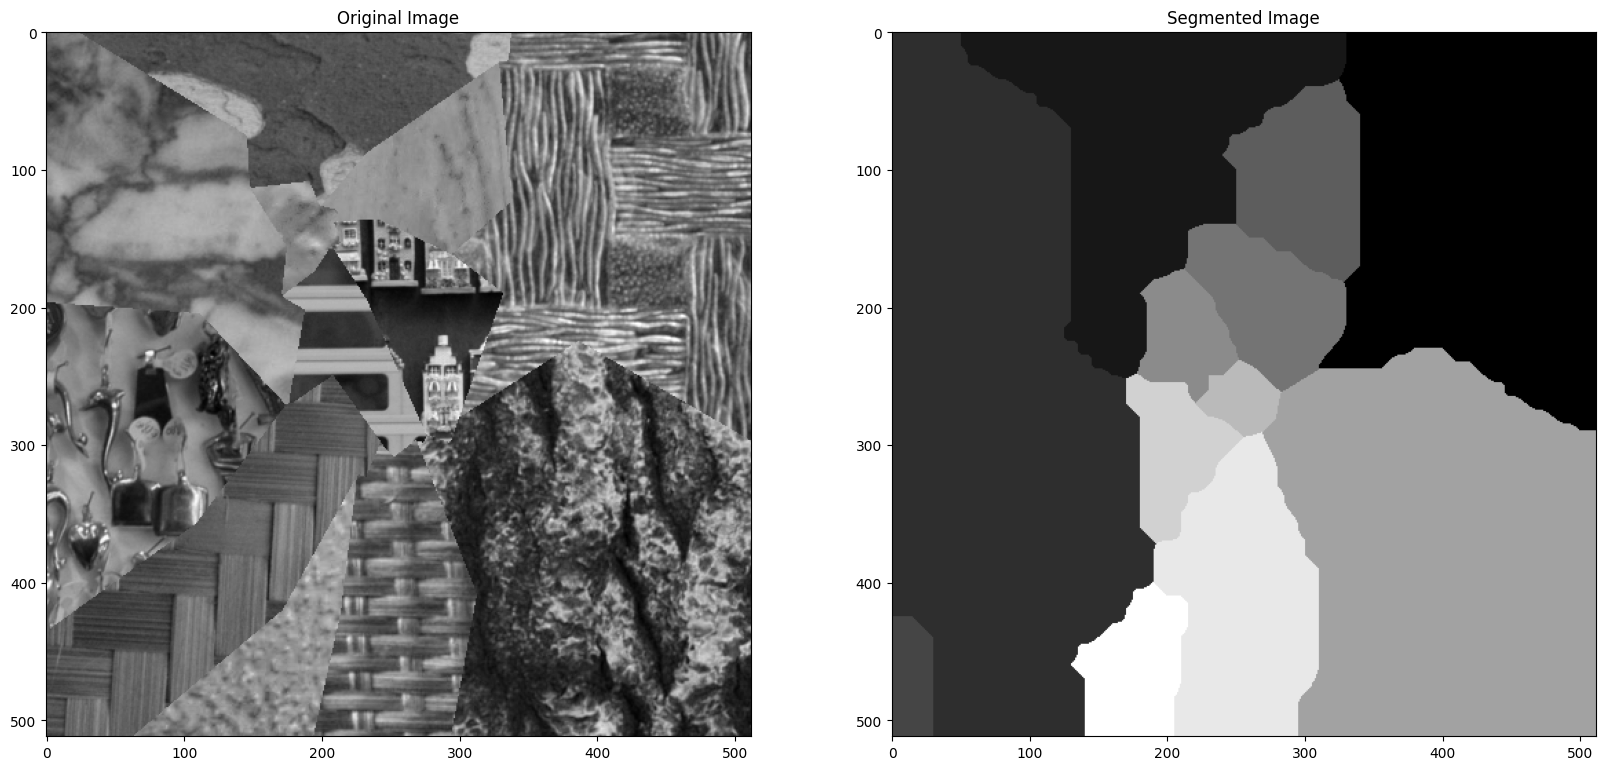

In [9]:
def interpolation(segs):
    img = segs
    # Find the coordinates of zero and non-zero values
    zero_coords = np.argwhere(img == 0)
    non_zero_coords = np.argwhere(img != 0)

    for zero_coord in zero_coords:
        # Calculate distances from the current zero position to all non-zero positions
        distances = np.linalg.norm(non_zero_coords - zero_coord, axis=1)

        # Find the index of the closest non-zero value
        closest_index = non_zero_coords[np.argmin(distances)]

        # Fill the zero value with the closest non-zero value
        img[zero_coord[0], zero_coord[1]] = img[closest_index[0], closest_index[1]]

    return img

final_outp = interpolation(almost_segs)
compare_img(image, final_outp)

<br>

### __*Result*__

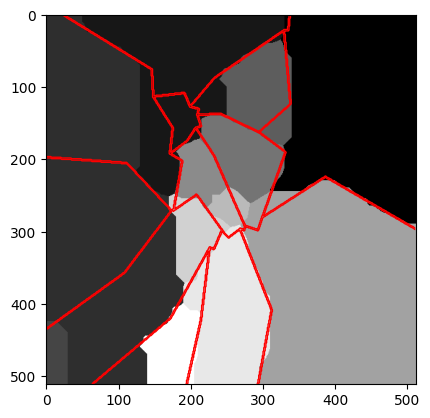

In [10]:
plt.imshow(final_outp, cmap='gray')
plt.contour(image_mask, levels=[0.5], colors='red', linewidths=1)
plt.show()

<br>

### __*Process-Automation*__

In [11]:
def segmentation(img):
    fourier = furrier(img)
    edges = edge_finder(fourier)
    beta_mask = masker(edges[0])
    final_mask = maskerer(beta_mask)
    wannabe_segs = blocky(final_mask)
    # finally_segs = interpolation(wannabe_segs)
    #
    # return finally_segs
    return wannabe_segs

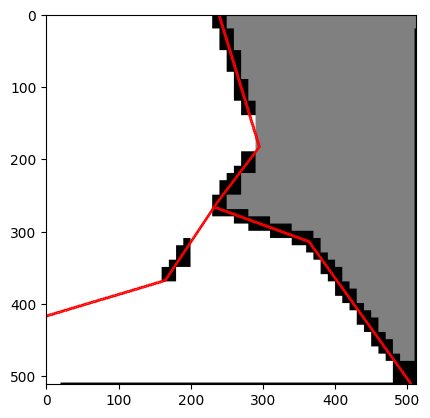

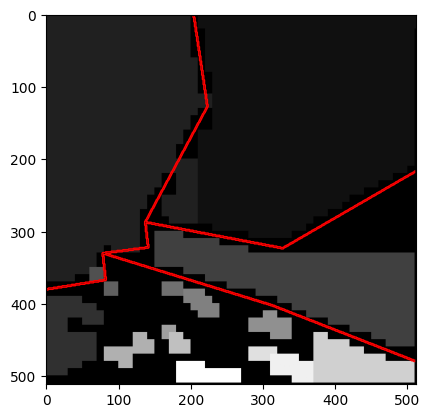

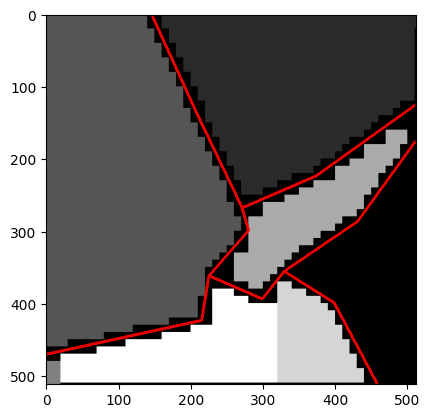

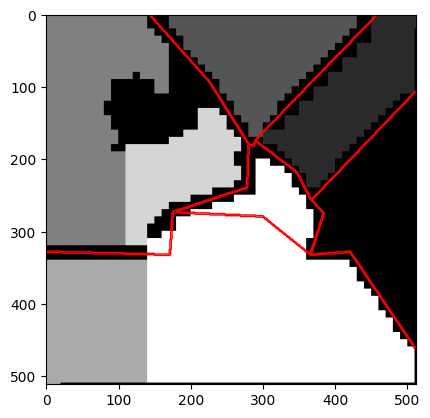

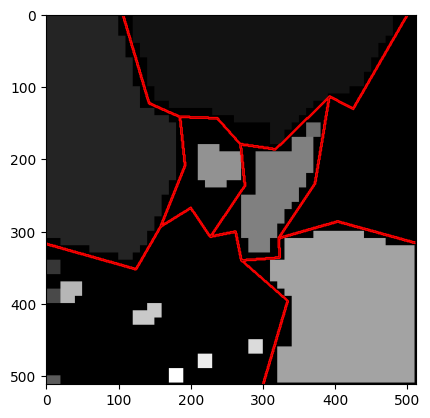

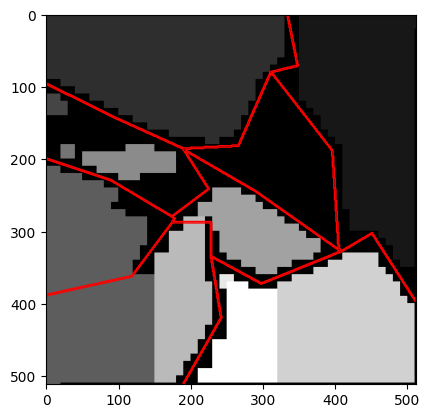

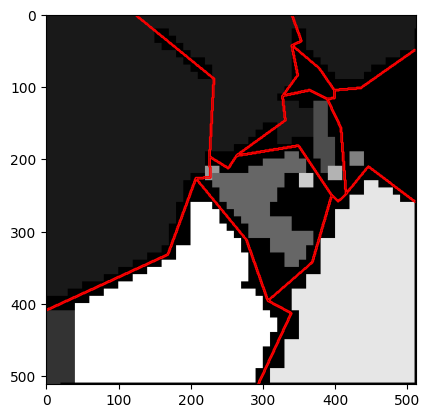

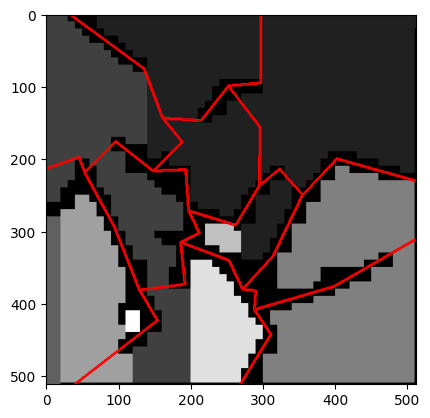

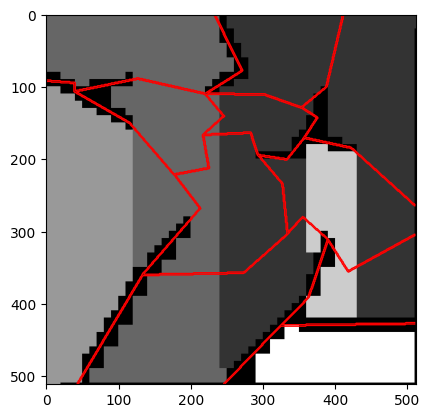

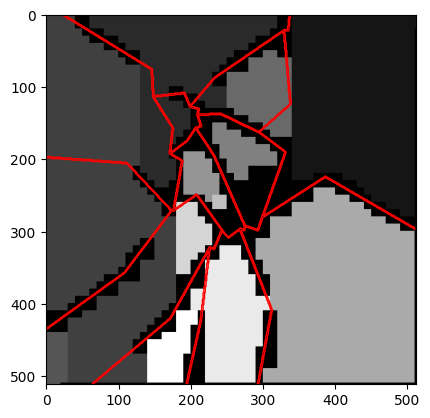

In [12]:
N_OF_IMAGES = 10

for i in range(1, N_OF_IMAGES+1):
    tm_path = ''.join(['textury_train/tm', str(i), '_1_1.png'])
    mk_path = ''.join(['textury_train/mask', str(i), '_1.png'])
    image = io.imread(tm_path).astype(np.uint8)
    image_mk = io.imread(mk_path).astype(np.uint8)

    finally_segs = segmentation(image)

    plt.imshow(finally_segs, cmap='gray')
    plt.contour(image_mk, levels=[0.5], colors='red', linewidths=1)
    plt.show()